# Extent of the Identifiability Problem
## We are aiming to see how the specific data seed impacts the constant choosen by the model

Data Properties to record: Data Mean, Data Variance, Data Other Moments, Data Maximum and Minimum, Data Range.

Results Properties to record: Magnitude of added constant, sign of added constant, size of sigma1^2, the constant kernel term, size of sigma_0^2, likelihood, NLL

In [39]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [41]:
# --- Generate synthetic 2D data ---
def true_function(X):
    x1, x2 = X[:,0], X[:,1]
    return np.sin(x1*2) + 3*x2**3 + x1*np.sin(x2*2)
    #return x1**2 - 2*x2 + np.cos(3*x1)*np.sin(5*x2) # other models have different important properties


# --- Define the true functions ---
true_f1 = lambda x: np.sin(2*x)
true_f2 = lambda x: 3*x**3
true_f12 = lambda X: X[:,0]*np.sin(2*X[:,1])

#true_f1 = lambda x: x**2
#true_f2 = lambda x: -2*x
#true_f12 = lambda X: np.cos(3*X[:,0])*np.sin(5*X[:,1])



n = 1000
noise = 0.01
X = np.random.normal(0, 1, size=(n,2))
y = true_function(X) + np.random.normal(0, noise, size=n)
y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std

In [7]:
# --- Create AGP model ---
data = (X, y)
model = create_model_oak(
        data=data,
        max_interaction_depth=2,
        constrain_orthogonal=False,
        share_var_across_orders=True,
        use_sparsity_prior=False,
)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(model)


model_nll = model.training_loss()
print(f"NLL is {model_nll}")

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   2.49287  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.54151  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.variances[0]            │ Parameter │ Softplus         │         │ True        │ ()      │ float64

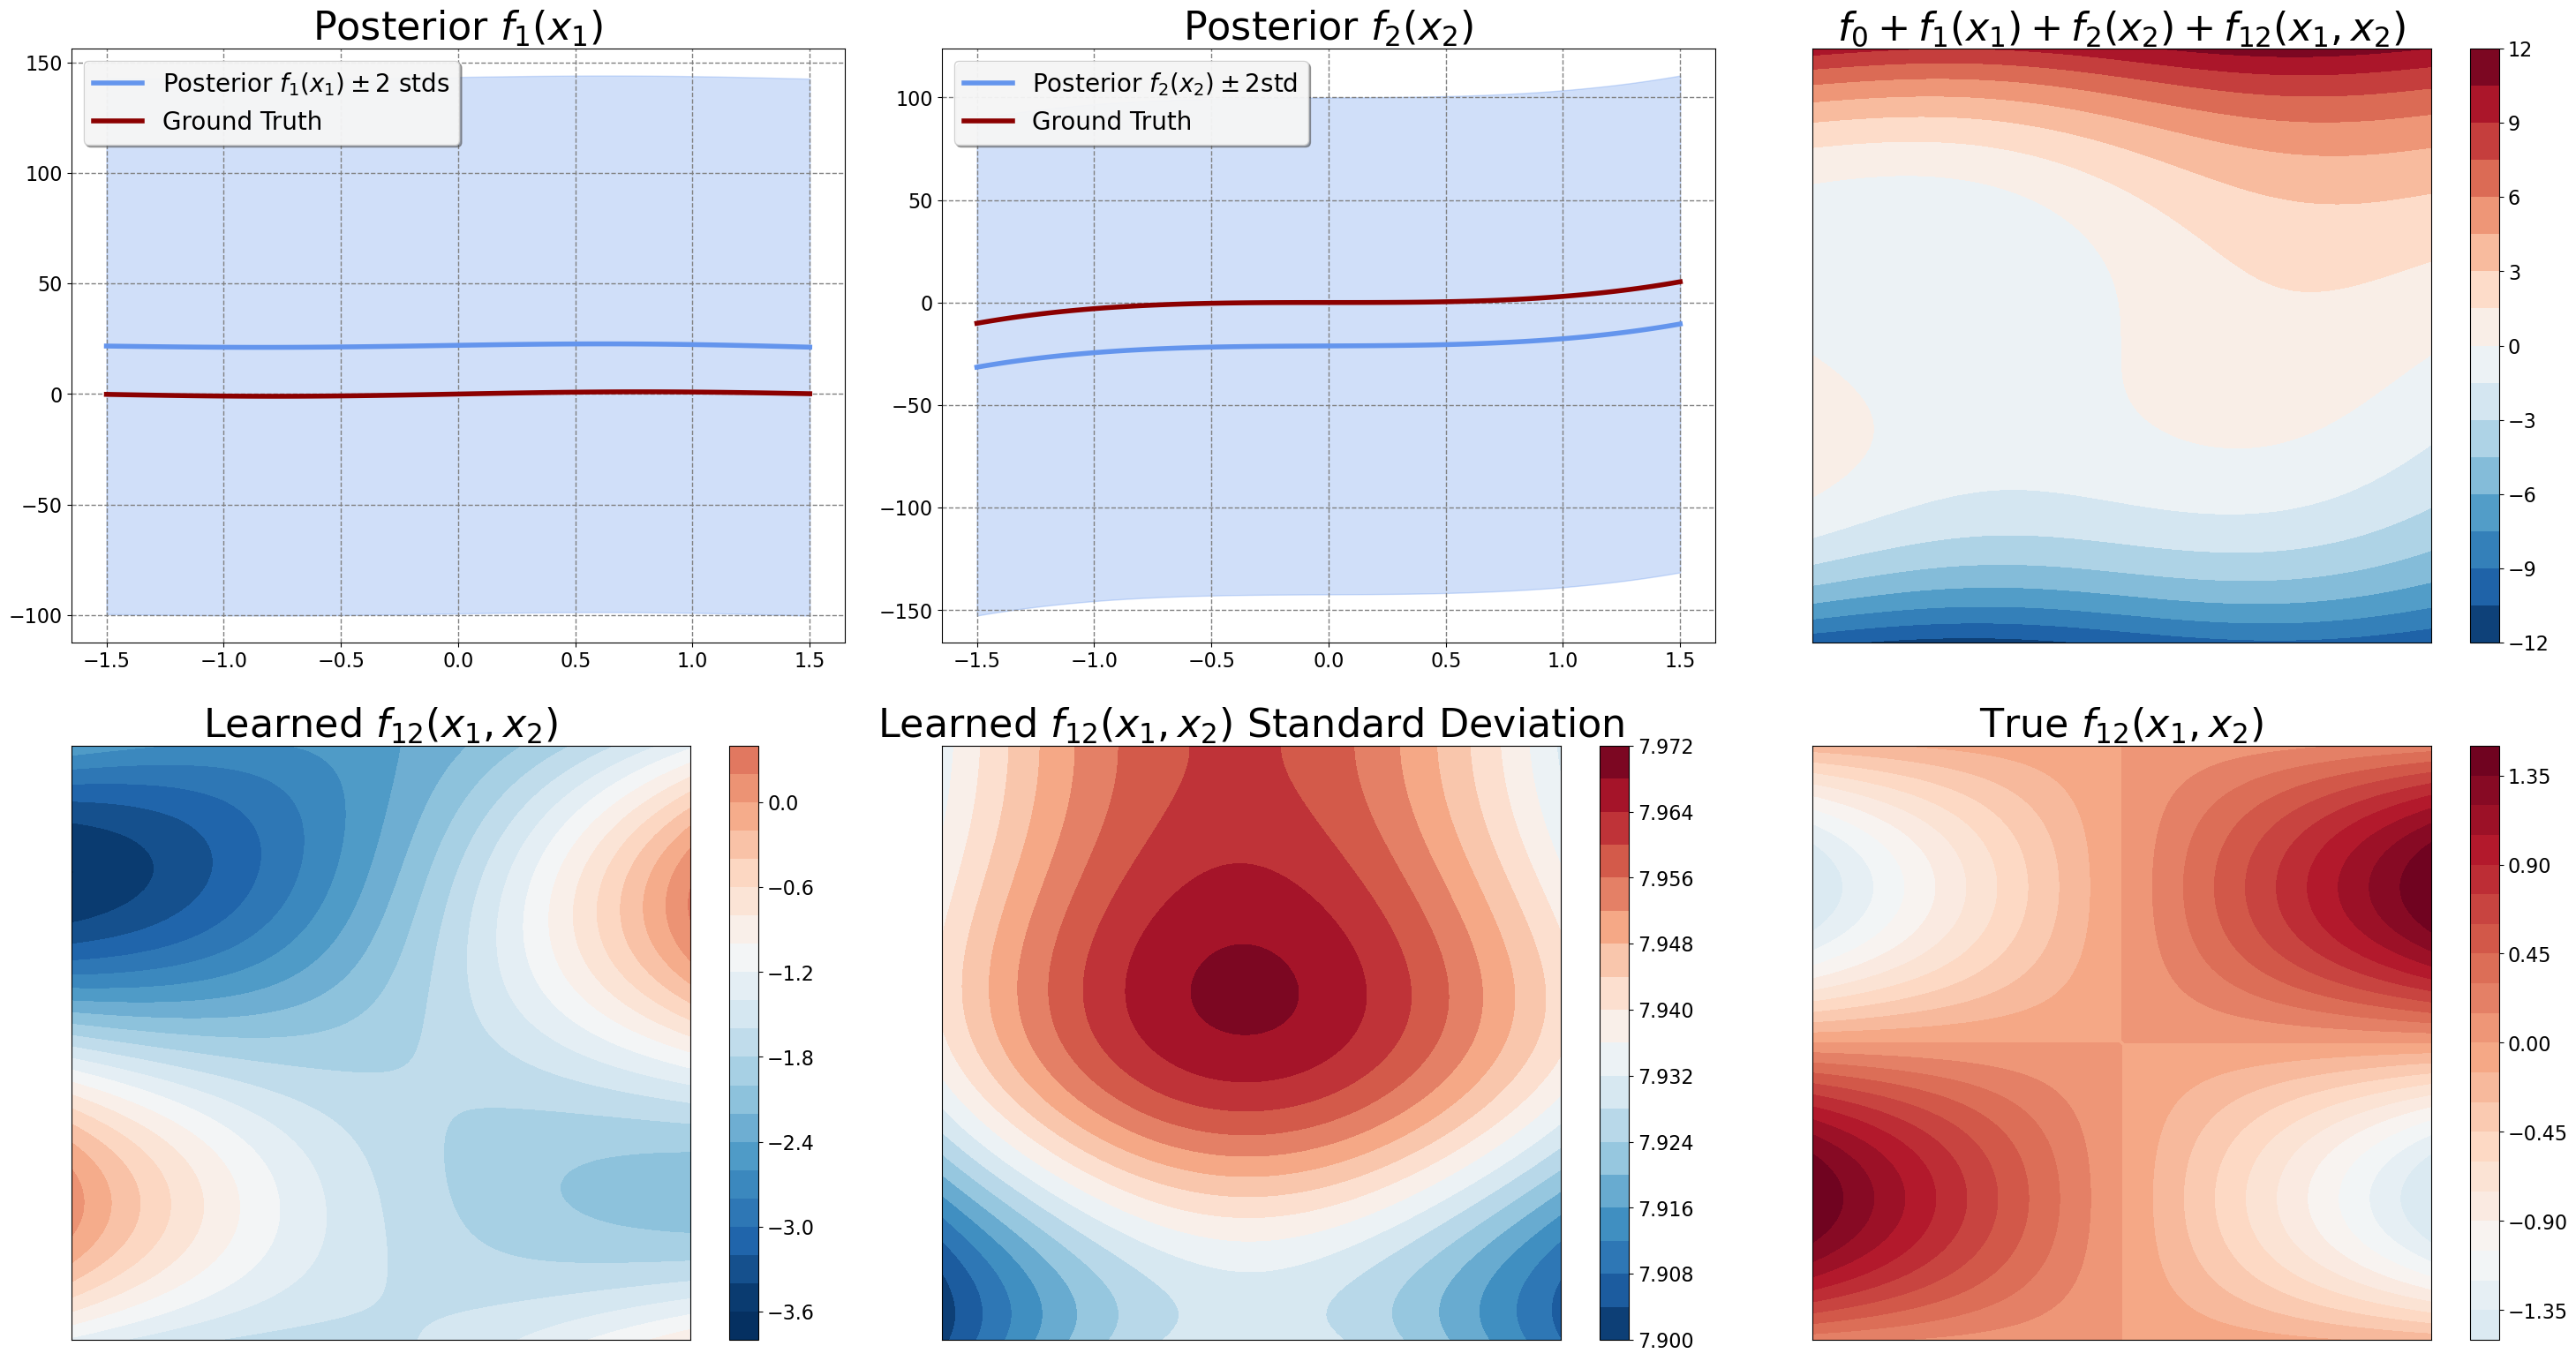

In [14]:
N = 10000
X_samples = np.random.normal(0, 1, size=(N, 2))
X_train = model.data[0].numpy()
alpha = get_model_sufficient_statistics(model, get_L=False)
selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=2)



# --- Meshgrid for plotting ---
x1_plot = np.linspace(-1.5, 1.5, 100)
x2_plot = np.linspace(-1.5, 1.5, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)
X_grid_f1 = np.stack([X1_grid.ravel(), np.zeros_like(X1_grid).ravel()], axis=1)
X_grid_f1_tf = tf.convert_to_tensor(X_grid_f1, dtype=tf.float64)
X_grid_f2 = np.stack([np.zeros_like(X2_grid).ravel(), X2_grid.ravel()], axis=1)
X_grid_f2_tf = tf.convert_to_tensor(X_grid_f2, dtype=tf.float64)


# --- Build inputs with fixed variables for f1 and f2 ---
X_plot_f1 = np.copy(X_grid)
X_plot_f1[:, 1] = 0
X_plot_f2 = np.copy(X_grid)
X_plot_f2[:, 0] = 0
X_plot_f12 = X_grid


# --- Evaluate function ---
f0_vals = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f1_vals = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(X_plot_f1, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f2_vals = eval_component(kernel_list[2], alpha, tf.convert_to_tensor(X_plot_f2, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f12_vals = eval_component(kernel_list[3], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)


# --- Posterior Variances ---
K_yy = model.kernel.K(X_train, X_train) + tf.eye(len(X_train), dtype=tf.float64) * model.likelihood.variance.numpy()

# Variance for f0
var_f0_tensor = get_component_variance(kernel_list[0], K_yy, X_grid_tf, X_train)
var_f0 = var_f0_tensor.numpy().reshape(100, 100)
std_f0 = np.sqrt(var_f0) * y_std

# Variance for f1
var_f1_tensor = get_component_variance(kernel_list[1], K_yy, X_grid_f1_tf, X_train)
var_f1 = var_f1_tensor.numpy().reshape(100, 100)
std_f1 = np.sqrt(np.mean(var_f1, axis=0)) * y_std

# Variance for f2
var_f2_tensor = get_component_variance(kernel_list[2], K_yy, X_grid_f2_tf, X_train)
var_f2 = var_f2_tensor.numpy().reshape(100, 100)
std_f2 = np.sqrt(np.mean(var_f2, axis=0)) * y_std

# Variance for f12
var_f12_tensor = get_component_variance(kernel_list[3], K_yy, X_grid_tf, X_train)
var_f12 = var_f12_tensor.numpy().reshape(100, 100)
std_f12 = np.sqrt(var_f12) * y_std

# Variance for the overall model
var_overall_tensor = get_component_variance(model.kernel, K_yy, X_grid_tf, X_train)
var_overall = var_overall_tensor.numpy().reshape(100, 100)
std_overall = np.sqrt(var_overall) * y_std




# --- Denorrmalise ---
f_sum = (f0_vals + f1_vals + f2_vals + f12_vals) * y_std + y_mean
f0_vals = f0_vals * y_std + y_mean
f1_vals = f1_vals * y_std
f2_vals = f2_vals * y_std
f12_vals = f12_vals * y_std
f_true = true_function(X_grid).reshape(100,100)


# --- 1D plots of f1(x1), f2(x2) ---
f1_x1 = np.mean(f1_vals, axis=0)
f1_true = true_f1(x1_plot)
f2_x2 = np.mean(f2_vals, axis=1)
f2_true = true_f2(x2_plot)
f12_true = true_f12(X_grid).reshape(100,100)

f12_x1 = np.mean(f12_vals, axis=0)
f12_x2 = np.mean(f12_vals, axis=1)
f12_x1_true = np.mean(f12_true, axis=0)
f12_x2_true = np.mean(f12_true, axis=1)


# --- Plot the results ---
fig, axes = plt.subplots(2, 3, figsize=(30, 16))

# f1
axes[0, 0].plot(x1_plot, f1_x1, label='Posterior $f_1(x_1) \\pm 2$ stds', color='cornflowerblue', linewidth=4)
axes[0, 0].fill_between(x1_plot, f1_x1 - 2*std_f1, f1_x1 + 2*std_f1, color='cornflowerblue', alpha=0.3)
axes[0, 0].plot(x1_plot, f1_true, label='Ground Truth', color='darkred', linewidth=4)
axes[0, 0].set_title("Posterior $f_1(x_1)$")
axes[0, 0].grid(True)
axes[0, 0].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f2
axes[0, 1].plot(x2_plot, f2_x2, label='Posterior $f_2(x_2) \\pm 2$std', color='cornflowerblue', linewidth=4)
axes[0, 1].fill_between(x2_plot, f2_x2 - 2*std_f2, f2_x2 + 2*std_f2, color='cornflowerblue', alpha=0.3)
axes[0, 1].plot(x2_plot, f2_true, label='Ground Truth', color='darkred', linewidth=4)
axes[0, 1].set_title("Posterior $f_2(x_2)$")
axes[0, 1].grid(True)
axes[0, 1].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f_total
cont2 = axes[0, 2].contourf(X1_grid, X2_grid, f_sum, levels=20, cmap='RdBu_r')
axes[0, 2].set_title("$f_0 + f_1(x_1) + f_2(x_2) + f_{12}(x_1,x_2)$")
fig.colorbar(cont2, ax=axes[0, 2])
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])


vmin = min(f12_vals.min(), f12_true.min())
vmax = max(f12_vals.max(), f12_true.max())


# Learned f12
cont = axes[1, 0].contourf(X1_grid, X2_grid, f12_vals, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1, 0].set_title("Learned $f_{12}(x_1, x_2)$")
fig.colorbar(cont, ax=axes[1, 0])
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

# Interaction Standard Deviation
cont3 = axes[1, 1].contourf(X1_grid, X2_grid, std_f12, levels=20, cmap='RdBu_r')
axes[1, 1].set_title("Learned $f_{12}(x_1, x_2)$ Standard Deviation")
fig.colorbar(cont3, ax=axes[1, 1])
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])


# True f12
cont = axes[1, 2].contourf(X1_grid, X2_grid, f12_true, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1, 2].set_title("True $f_{12}(x_1, x_2)$")
fig.colorbar(cont, ax=axes[1, 2])
axes[1, 2].set_xticks([])
axes[1, 2].set_yticks([])




plt.tight_layout(pad=2.0)
plt.show()

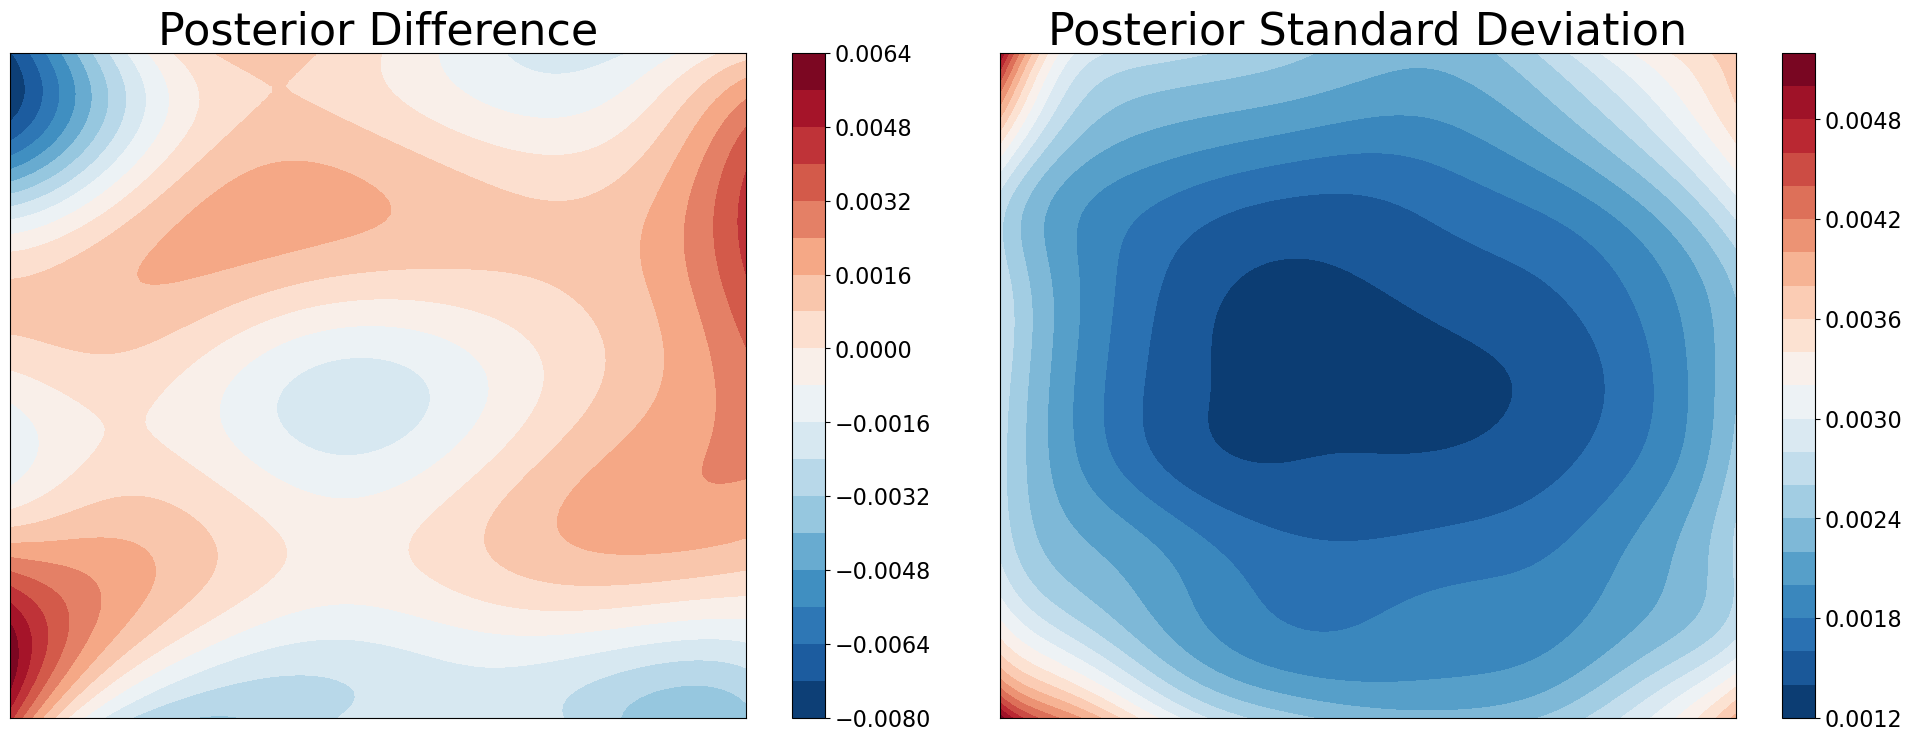

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Predictive Difference
cont3 = axes[0].contourf(X1_grid, X2_grid, f_true - f_sum, levels=20, cmap='RdBu_r')
axes[0].set_title("Posterior Difference")
fig.colorbar(cont3, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])

# Predictive Difference
cont3 = axes[1].contourf(X1_grid, X2_grid, std_overall, levels=20, cmap='RdBu_r')
axes[1].set_title("Posterior Standard Deviation")
fig.colorbar(cont3, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout(pad=2.0)
plt.show()

In [20]:
# --- Record data from different training data sets ---
num_seeds = 50

data_mean = []
data_std = []
data_skew = []
data_x1_skew = []
data_x2_skew = []
data_kurtosis = []
data_max = []
data_min = []
data_range = []

f1_const_offset = []
f2_const_offset = []
sigma_0_sq = []
sigma_1_sq = []
sigma_2_sq = []
ls1 = []
ls2 = []
const_size = []
likelihood = []
nll = []


for seed in range(num_seeds):

    # --- Collect Data Values ---
    np.random.seed(seed)
    tf.random.set_seed(seed)

    X = np.random.normal(0, 1, size=(n,2))
    y = true_function(X) + np.random.normal(0, noise, size=n)
    y = y.reshape(-1, 1)

    data_x1_skew.append(stats.moment(X[:,0], moment=3))
    data_x2_skew.append(stats.moment(X[:,1], moment=3))
    
    y_mean, y_std = np.mean(y), np.std(y)
    y = (y - y_mean) / y_std

    data_mean.append(y_mean)
    data_std.append(y_std)
    data_kurtosis.append(stats.moment(y, moment=4))
    data_skew.append(stats.moment(y, moment=3))
    data_max.append(y.max())
    data_min.append(y.min())
    data_range.append(y.max() - y.min())

    # --- Collect Model Values ---

    # --- Create AGP model ---
    data = (X, y)
    model = create_model_oak(
            data=data,
            max_interaction_depth=2,
            constrain_orthogonal=False,
            share_var_across_orders=True,
            use_sparsity_prior=False,
    )

    # --- Train model ---
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

    sigma_0_sq.append(model.kernel.variances[0].numpy())
    sigma_1_sq.append(model.kernel.variances[1].numpy())
    sigma_2_sq.append(model.kernel.variances[2].numpy())
    ls1.append(model.kernel.kernels[0].lengthscales.numpy())
    ls2.append(model.kernel.kernels[1].lengthscales.numpy())
    likelihood.append(model.likelihood.variance.numpy())
    nll.append(model.training_loss())

    
    X_train = model.data[0].numpy()
    alpha = get_model_sufficient_statistics(model, get_L=False)
    selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=2)

    f0_vals = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
    f1_vals = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(X_plot_f1, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
    f2_vals = eval_component(kernel_list[2], alpha, tf.convert_to_tensor(X_plot_f2, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)

    f_sum = (f0_vals + f1_vals + f2_vals + f12_vals) * y_std + y_mean
    f0_vals = f0_vals * y_std
    f1_vals = f1_vals * y_std
    f2_vals = f2_vals * y_std

    const_size.append(np.mean(f0_vals[0]))
    f1_const_offset.append(np.mean(f1_vals[0] - f1_true[0]))
    f2_const_offset.append(np.mean(f2_vals[0] - f2_true[0]))

In [21]:
all_data = {
    "Data Mean": data_mean,
    "Data Std Dev": data_std,
    "Data Skewness": data_skew,
    "$x_1$ Skewness": data_x1_skew,
    "$x_2$ Skewness": data_x2_skew,
    "Data Kurtosis": data_kurtosis,
    "Data Max": data_max,
    "Data Min": data_min,
    "Data Range": data_range,
    "$f_1$ Offset": f1_const_offset,
    "$f_2$ Offset": f2_const_offset,
    "$\\sigma_0^2$": np.ravel(sigma_0_sq),
    "$\\sigma_1^2$": np.ravel(sigma_1_sq),
    "$\\sigma_2^2$": np.ravel(sigma_2_sq),
    "Lengthscale 1": ls1,
    "Lengthscale 2": ls2,
    "Constant Size": const_size,
    "Likelihood Var": np.ravel(likelihood),
    "NLL": nll,
}
df = pd.DataFrame(all_data)
if df['Likelihood Var'].nunique() == 1:
    df = df.drop('Likelihood Var', axis=1)
corr_matrix = df.corr()

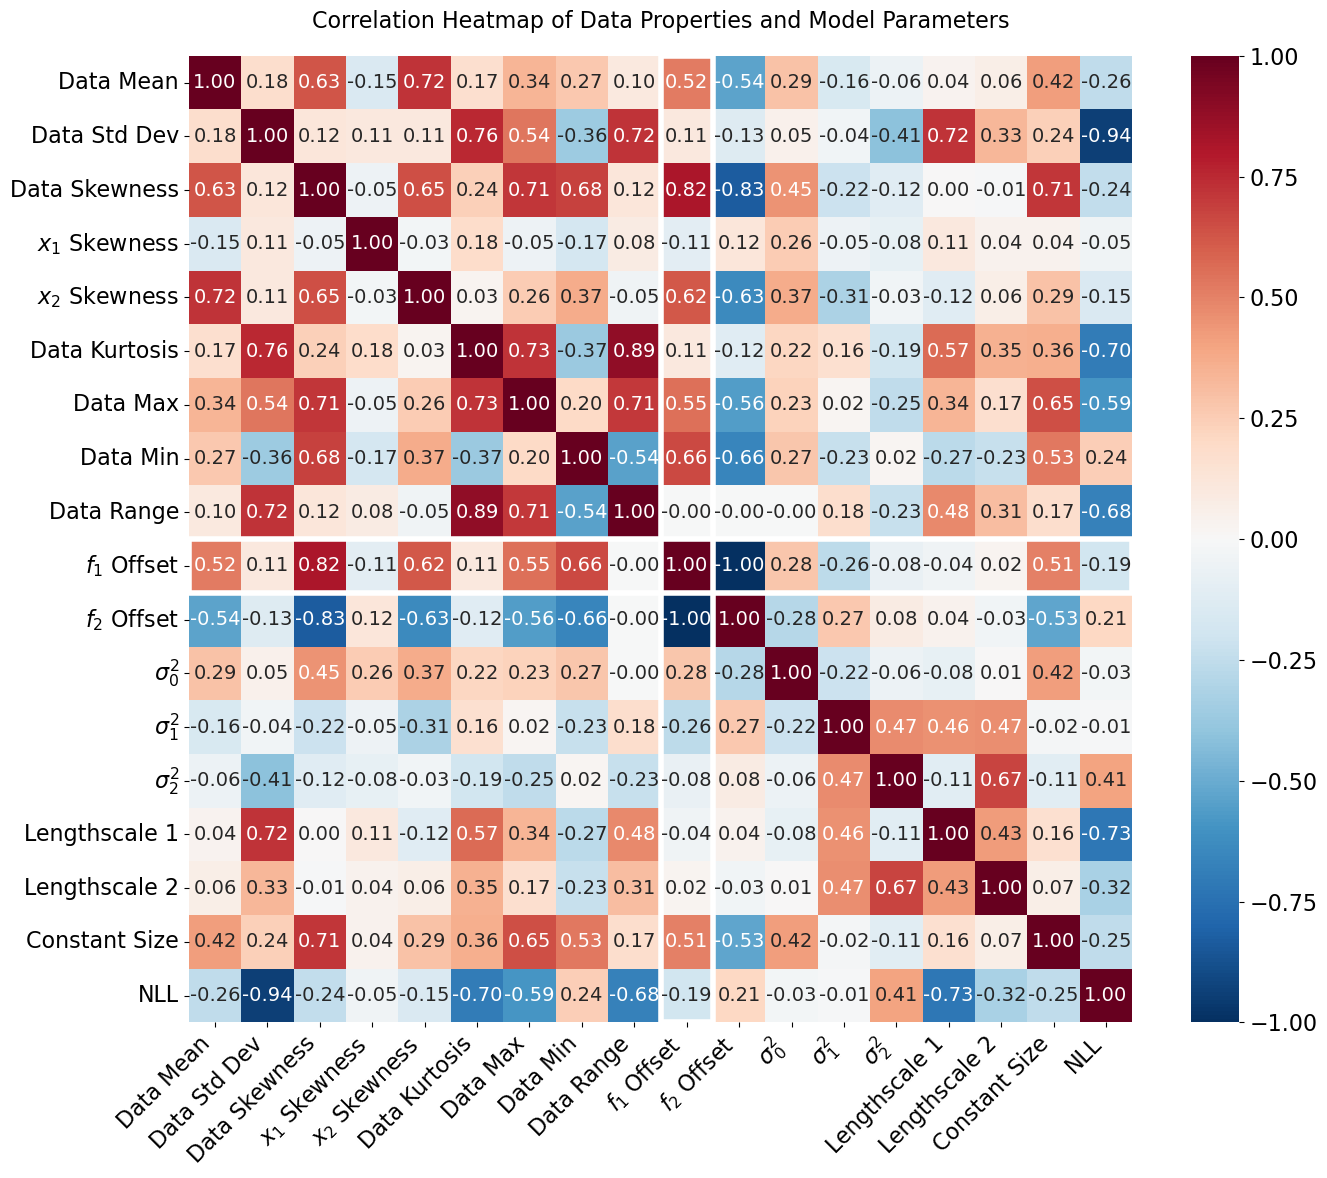

In [22]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", linewidths=0, ax=ax,vmin=-1, vmax=1, center=0)

ax.set_title("Correlation Heatmap of Data Properties and Model Parameters", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')

target_var = "$f_1$ Offset"
target_idx = df.columns.get_loc(target_var)
ax.add_patch(patches.Rectangle(xy=(target_idx, 0), width=1, height=len(df.columns), ec='white', fill=False, lw=4))
ax.add_patch(patches.Rectangle(xy=(0, target_idx), height=1, width=len(df.columns), ec='white', fill=False, lw=4))

plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

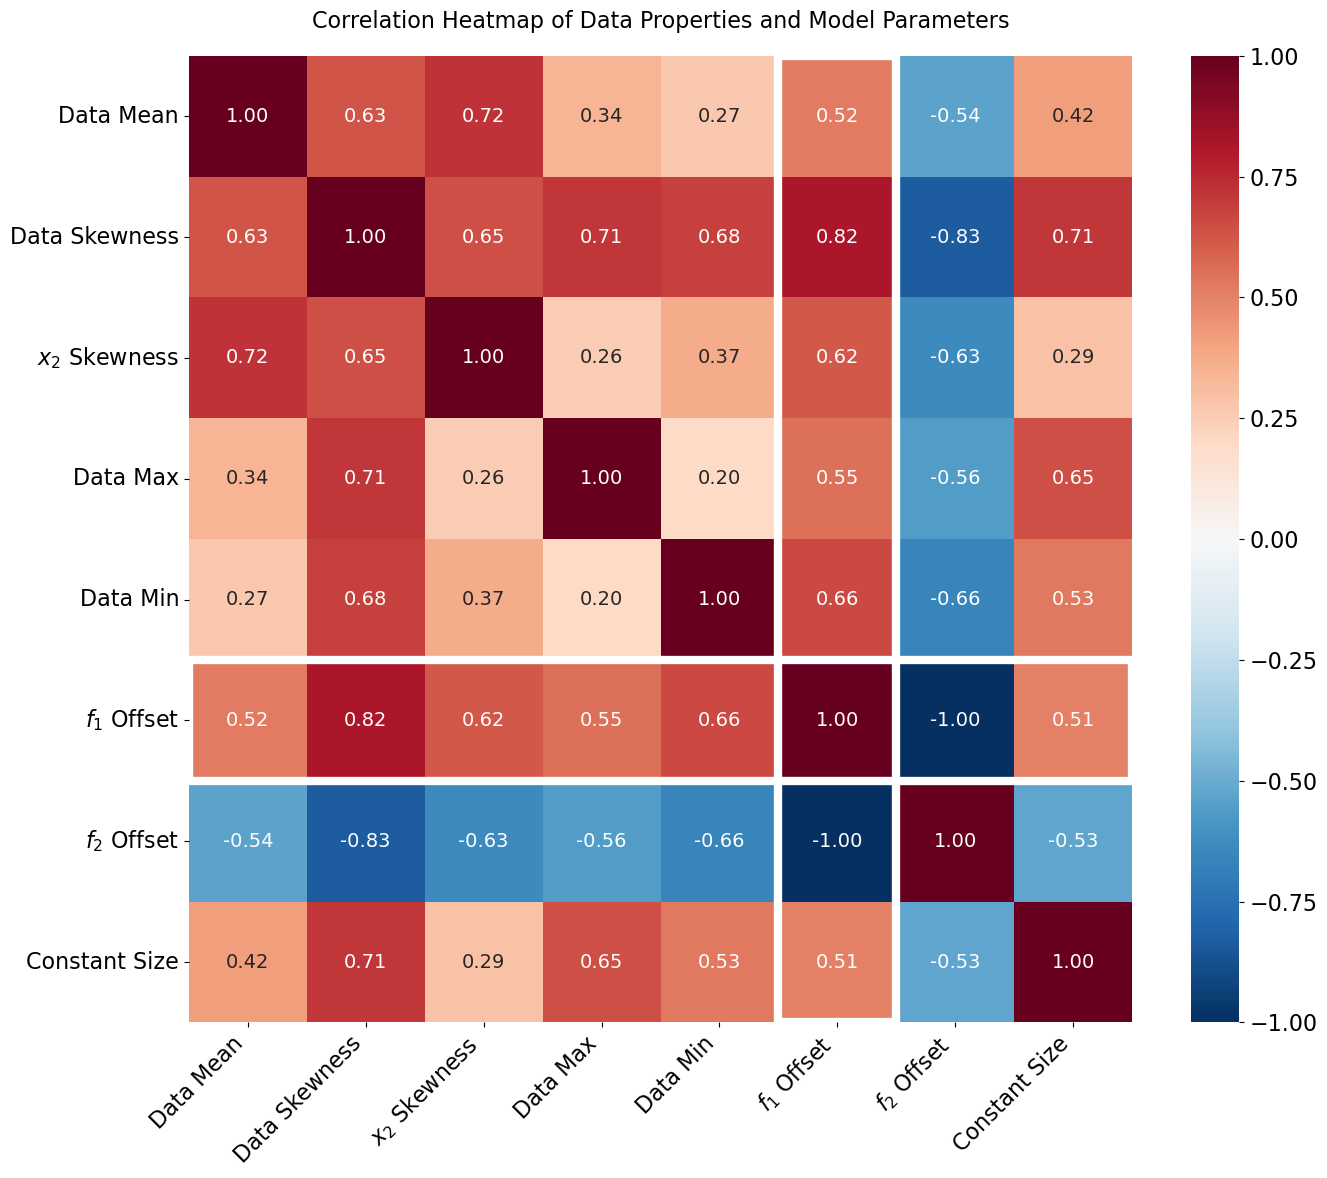

In [23]:
f1_correlations = corr_matrix['$f_1$ Offset']
significant_vars = f1_correlations[f1_correlations.abs() > 0.3].index.tolist()
filtered_corr_matrix = corr_matrix.loc[significant_vars, significant_vars]

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", linewidths=0, ax=ax,vmin=-1, vmax=1, center=0)

ax.set_title("Correlation Heatmap of Data Properties and Model Parameters", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')

target_var = "$f_1$ Offset"
target_idx = filtered_corr_matrix.columns.get_loc(target_var)
num_vars = len(filtered_corr_matrix.columns)
ax.add_patch(patches.Rectangle(xy=(target_idx, 0), width=1, height=num_vars, ec='white', fill=False, lw=6))
ax.add_patch(patches.Rectangle(xy=(0, target_idx), height=1, width=num_vars, ec='white', fill=False, lw=6))

plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Heatmap')
plt.show()

# The Size of the offset chosen by the model is sensitive to the shape and tails of the training data distribution.
Repeating the experiment with the other ground truth function verifies that different properties of the data are important for different functions.